In [1]:
import torchvision
import torch.optim as optim
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/PASCAL'

# Training

## getting pre saved model

In [2]:
!gdown --id "1D4u6_OG5jTkhp-QlJouyBUWjHmKNCoij"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1D4u6_OG5jTkhp-QlJouyBUWjHmKNCoij
To: /content/model.pth
100% 168M/168M [00:00<00:00, 302MB/s]


In [ ]:
!gdown --id "1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai"
!unzip 'PASCAL.zip' -d '/content/PASCAL'

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
model.load_state_dict(torch.load('/content/model.pth',map_location=torch.device('cpu')))
model=model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 335MB/s]


## making dataloaders


In [6]:
from pascal_dataset import PASCALDataset
from utils import collate_fn
train=PASCALDataset('/content/PASCAL/PASCAL/train')
val=PASCALDataset('/content/PASCAL/PASCAL/val')
test=PASCALDataset('/content/PASCAL/PASCAL/test')
trainloader=torch.utils.data.DataLoader(train,shuffle=True,
                                        num_workers=0,collate_fn=collate_fn)
testloader=torch.utils.data.DataLoader(test,shuffle=False,
                                        num_workers=0,collate_fn=collate_fn)
valloader=torch.utils.data.DataLoader(val,shuffle=False,
                                        num_workers=0,collate_fn=collate_fn)

## training loop

In [ ]:
from engine import train_one_epoch,evaluate
epoch_num=5
optimizer=optim.Adam(model.parameters(),lr=1e-6)
torch.cuda.empty_cache()
for epoch in range(epoch_num):
  train_one_epoch(model,optimizer,trainloader,device,epoch,print_freq=100)
  evaluate(model,valloader,device)

Epoch: [0]  [   0/1002]  eta: 0:04:29  lr: 0.000000  loss: 0.0676 (0.0676)  loss_classifier: 0.0245 (0.0245)  loss_box_reg: 0.0238 (0.0238)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0168 (0.0168)  time: 0.2686  data: 0.0189  max mem: 5743
Epoch: [0]  [ 100/1002]  eta: 0:04:19  lr: 0.000000  loss: 0.1948 (0.2673)  loss_classifier: 0.0998 (0.1044)  loss_box_reg: 0.1290 (0.1270)  loss_objectness: 0.0041 (0.0173)  loss_rpn_box_reg: 0.0109 (0.0187)  time: 0.2864  data: 0.0138  max mem: 6388
Epoch: [0]  [ 200/1002]  eta: 0:03:49  lr: 0.000000  loss: 0.1326 (0.2518)  loss_classifier: 0.0593 (0.0996)  loss_box_reg: 0.0482 (0.1211)  loss_objectness: 0.0046 (0.0132)  loss_rpn_box_reg: 0.0086 (0.0178)  time: 0.2887  data: 0.0144  max mem: 6388
Epoch: [0]  [ 300/1002]  eta: 0:03:19  lr: 0.000000  loss: 0.1676 (0.2376)  loss_classifier: 0.0632 (0.0926)  loss_box_reg: 0.0810 (0.1150)  loss_objectness: 0.0027 (0.0128)  loss_rpn_box_reg: 0.0093 (0.0173)  time: 0.2783  data: 0.0127  max me

In [ ]:
from engine import evaluate
tested=evaluate(model,testloader,device)

## saving model

In [ ]:
%pwd
torch.save(model.state_dict(), 'model.pth')

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Evaluate

In [7]:
label_color={5:{'name':'airplane','color':'green'},
            3:{'name':'car','color':'orange'},
            1:{'name':'person','color':'red'},
            2:{'name':'bicycle','color':'blue'},
            4:{'name':'motorbike','color':'purple'}  
}

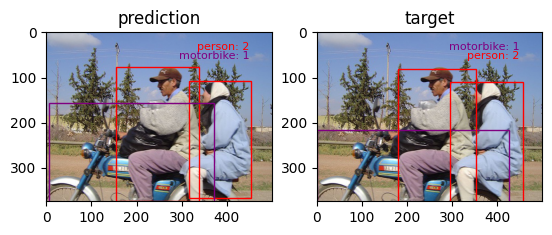

In [13]:
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict
label_counts = defaultdict(int)
img, target = test[18]
img=img.to(device)
#next(iter(testloader))
image = img.cpu().permute(1, 2, 0).numpy()
plt.subplot(1, 2, 1)
plt.title('prediction')
plt.imshow(image)
model.eval()
prediction = model([img])
boxes = prediction[0]['boxes'].cpu()
labels = prediction[0]['labels']
scores=prediction[0]['scores']
ax=plt.gca()
for box,label,score in zip(boxes,labels,scores):
  if(score>0.8):
    label_counts[int(label)]+=1
    rect=patches.Rectangle((box[0].detach(),box[1].detach()),
                          (box[2].detach()-box[0].detach()),
                          (box[3].detach()-box[1].detach()),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    rect.set_label(label)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1
plt.subplot(1,2,2)
plt.title('target')
plt.imshow(image)
boxes=target['boxes']
label_counts = defaultdict(int)
labels=target['labels']
for label in labels:
    label_counts[int(label)] += 1
ax=plt.gca()
for box,label in zip(boxes,labels):
    rect=patches.Rectangle((box[0],box[1]),
                          (box[2]-box[0]),
                          (box[3]-box[1]),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1

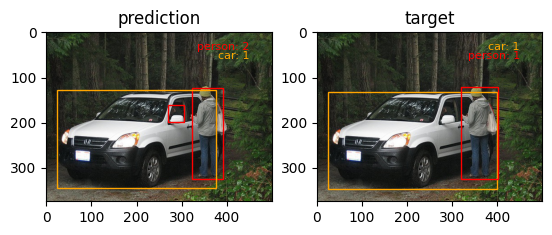

In [20]:
label_counts = defaultdict(int)
img, target = test[22]
img=img.to(device)
#next(iter(testloader))
image = img.cpu().permute(1, 2, 0).numpy()
plt.subplot(1, 2, 1)
plt.title('prediction')
plt.imshow(image)
model.eval()
prediction = model([img])
boxes = prediction[0]['boxes'].cpu()
labels = prediction[0]['labels']
scores=prediction[0]['scores']
ax=plt.gca()
for box,label,score in zip(boxes,labels,scores):
  if(score>0.8):
    label_counts[int(label)]+=1
    rect=patches.Rectangle((box[0].detach(),box[1].detach()),
                          (box[2].detach()-box[0].detach()),
                          (box[3].detach()-box[1].detach()),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    rect.set_label(label)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1
plt.subplot(1,2,2)
plt.title('target')
plt.imshow(image)
boxes=target['boxes']
label_counts = defaultdict(int)
labels=target['labels']
for label in labels:
    label_counts[int(label)] += 1
ax=plt.gca()
for box,label in zip(boxes,labels):
    rect=patches.Rectangle((box[0],box[1]),
                          (box[2]-box[0]),
                          (box[3]-box[1]),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1

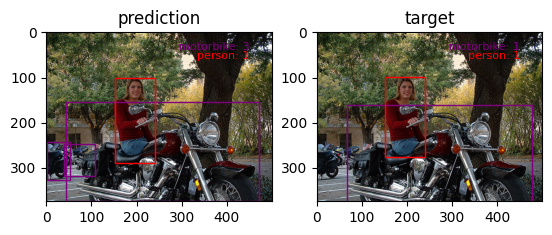

In [25]:
label_counts = defaultdict(int)
img, target = test[62]
img=img.to(device)
#next(iter(testloader))
image = img.cpu().permute(1, 2, 0).numpy()
plt.subplot(1, 2, 1)
plt.title('prediction')
plt.imshow(image)
model.eval()
prediction = model([img])
boxes = prediction[0]['boxes'].cpu()
labels = prediction[0]['labels']
scores=prediction[0]['scores']
ax=plt.gca()
for box,label,score in zip(boxes,labels,scores):
  if(score>0.8):
    label_counts[int(label)]+=1
    rect=patches.Rectangle((box[0].detach(),box[1].detach()),
                          (box[2].detach()-box[0].detach()),
                          (box[3].detach()-box[1].detach()),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    rect.set_label(label)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1
plt.subplot(1,2,2)
plt.title('target')
plt.imshow(image)
boxes=target['boxes']
label_counts = defaultdict(int)
labels=target['labels']
for label in labels:
    label_counts[int(label)] += 1
ax=plt.gca()
for box,label in zip(boxes,labels):
    rect=patches.Rectangle((box[0],box[1]),
                          (box[2]-box[0]),
                          (box[3]-box[1]),
                          fill=False,
                          edgecolor=label_color[int(label)]['color'],
                          linewidth=1)
    ax.add_patch(rect)
k=0
for i in label_counts.keys():
  plt.text(image.shape[1]-50, 20+k*20, f"{label_color[i]['name']}: {label_counts[i]}",
  color=label_color[i]['color'], fontsize=8, ha='right', va='top')
  k+=1